In [13]:
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.python.keras.models import Sequential,model_from_json
from tensorflow.python.keras.preprocessing import image
from tensorflow.keras.callbacks            import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.python.keras.layers import Activation, Dropout, Flatten, Dense
from keras.applications import VGG16
from tensorflow.python.keras.optimizers import Adam
import numpy as np
from google.colab import files
import os 
from keras.preprocessing.image import img_to_array
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import os
import zipfile
import cv2
import shutil
import random
import pandas as pd
from matplotlib.image import imread
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

## UPLOADING FILES

---



In [2]:
file = files.upload()
p = os.path.abspath('kaggle.json')
print(p)

Saving kaggle.json to kaggle.json
/content/kaggle.json


In [3]:
!pip install kaggle

In [4]:
!mkdir ~/.kaggle
p = os.path.abspath('.kaggle')
print(p)
!ls

/content/.kaggle
kaggle.json  sample_data


In [5]:
!mv /content/kaggle.json ~/.kaggle
!kaggle competitions download -c dogs-vs-cats

  0% 0.00/86.8k [00:00<?, ?B/s]
100% 86.8k/86.8k [00:00<00:00, 32.1MB/s]
 95% 257M/271M [00:01<00:00, 146MB/s]
100% 271M/271M [00:02<00:00, 139MB/s]
 98% 535M/543M [00:03<00:00, 198MB/s]
100% 543M/543M [00:03<00:00, 181MB/s]


In [6]:
!unzip '/content/test1.zip'
!unzip '/content/train.zip'

Streaming output truncated to the last 5000 lines.
  inflating: train/dog.55.jpg        
  inflating: train/dog.550.jpg       
  inflating: train/dog.5500.jpg      
  inflating: train/dog.5501.jpg      
  inflating: train/dog.5502.jpg      
  inflating: train/dog.5503.jpg      
  inflating: train/dog.5504.jpg      
  inflating: train/dog.5505.jpg      
  inflating: train/dog.5506.jpg      
  inflating: train/dog.5507.jpg      
  inflating: train/dog.5508.jpg      
  inflating: train/dog.5509.jpg      
  inflating: train/dog.551.jpg       
  inflating: train/dog.5510.jpg      
  inflating: train/dog.5511.jpg      
  inflating: train/dog.5512.jpg      
  inflating: train/dog.5513.jpg      
  inflating: train/dog.5514.jpg      
  inflating: train/dog.5515.jpg      
  inflating: train/dog.5516.jpg      
  inflating: train/dog.5517.jpg      
  inflating: train/dog.5518.jpg      
  inflating: train/dog.5519.jpg      
  inflating: train/dog.552.jpg       
  inflating: train/dog.5520.jpg      

## Data Preparation

---



In [7]:
# Каталог с набором данных
data_dir = '/content/train'
# Каталог с данными для обучения
train_dir = 'train01'
# Каталог с данными для проверки
val_dir = 'val'
# Каталог с данными для тестирования
test_dir = 'test01'
# Часть набора данных для тестирования
test_data_portion = 0.15
# Часть набора данных для проверки
val_data_portion = 0.15
# Количество элементов данных в одном классе
nb_images = 12500

In [8]:
def create_directory(dir_name):
    if os.path.exists(dir_name):
        shutil.rmtree(dir_name)
    os.makedirs(dir_name)
    os.makedirs(os.path.join(dir_name, "cats"))
    os.makedirs(os.path.join(dir_name, "dogs"))

In [9]:
create_directory(train_dir)
create_directory(val_dir)
create_directory(test_dir)

In [10]:
def copy_images(start_index, end_index, source_dir, dest_dir):
    for i in range(start_index, end_index):
        shutil.copy2(os.path.join(source_dir, "cat." + str(i) + ".jpg"), 
                    os.path.join(dest_dir, "cats"))
        shutil.copy2(os.path.join(source_dir, "dog." + str(i) + ".jpg"), 
                   os.path.join(dest_dir, "dogs"))

In [11]:
start_val_data_idx = int(nb_images * (1 - val_data_portion - test_data_portion))
start_test_data_idx = int(nb_images * (1 - test_data_portion))
print(start_val_data_idx)
print(start_test_data_idx)

8750
10625


In [14]:
test = '/content/test1'
copy_images(0, start_val_data_idx, data_dir, train_dir)
copy_images(start_val_data_idx, start_test_data_idx, data_dir, val_dir)
copy_images(start_test_data_idx, nb_images, data_dir, test_dir)

In [15]:
img_width, img_height = 150, 150
input_shape = (img_width, img_height, 3)
batch_size = 10
nb_train_samples = 17500
nb_validation_samples = 3750
nb_test_samples = 3750

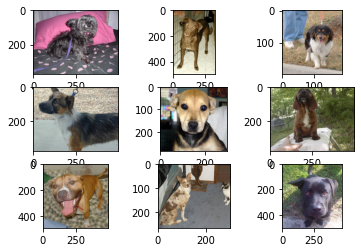

In [16]:
# define location of dataset
folder = '/content/train/'
# plot first few images
for i in range(9):
	# define subplot
	plt.subplot(330 + 1 + i)
	# define filename
	filename = folder + 'dog.' + str(i) + '.jpg'
	# load image pixels
	image = imread(filename)
	# plot raw pixel data
	plt.imshow(image)
# show the figure
plt.show()

## Creating model

---



---



In [17]:
vgg16_net = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

58892288/58889256 [==============================] - 1s 0us/step


In [18]:
datagen = ImageDataGenerator(rescale=1. / 255)

In [19]:
train_dir = '/content/train01'
train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(img_width,img_height),
    batch_size=batch_size,
    class_mode=None,
    shuffle=False)

Found 17500 images belonging to 2 classes.


In [20]:
val_generator = datagen.flow_from_directory(
    val_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode=None,
    shuffle=False)

Found 3750 images belonging to 2 classes.


In [21]:
test_generator = datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode=None,
    shuffle=False)

Found 3750 images belonging to 2 classes.


In [22]:
features_train = vgg16_net.predict_generator(
        train_generator, 
        nb_train_samples // batch_size)
np.save(open('/content/features_train.npy', 'wb'), features_train)

In [23]:
features_val = vgg16_net.predict_generator(
        val_generator, nb_validation_samples // batch_size)
np.save(open('/content/features_val.npy', 'wb'), features_val)

In [24]:
features_test = vgg16_net.predict_generator(
        test_generator, nb_test_samples // batch_size)
np.save(open('/content/features_test.npy', 'wb'), features_test)

In [25]:
labels_train =  np.array(
        [0] * (nb_train_samples // 2) + [1] * (nb_train_samples // 2))
labels_val =  np.array(
        [0] * (nb_validation_samples // 2) + [1] * (nb_validation_samples // 2))
labels_test =  np.array(
        [0] * (nb_test_samples // 2) + [1] * (nb_test_samples // 2))

In [26]:
features_train = np.load(open('features_train.npy', 'rb'))
features_val = np.load(open('features_val.npy', 'rb'))
features_test = np.load(open('features_test.npy', 'rb'))

In [27]:
def model_init_():
  model = Sequential()
  model.add(Flatten(input_shape=features_train.shape[1:]))
  model.add(Dense(512, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(1, activation='sigmoid'))
  return model
model = model_init_()

In [28]:
model.compile(optimizer='Adam',
              loss='binary_crossentropy', metrics=['accuracy'])

In [29]:
сheckpoint = ModelCheckpoint('content/mnist-cnn.h5', 
                              monitor='val_acc', 
                              save_best_only=True,
                              verbose=1)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [30]:
history = model.fit(features_train, labels_train,
              epochs=30,
              batch_size=64,
              validation_data=(features_val, labels_val), 
              verbose=2,
              callbacks=[сheckpoint, learning_rate_reduction])

Epoch 1/30
274/274 - 2s - loss: 0.3211 - accuracy: 0.8684 - val_loss: 0.2298 - val_accuracy: 0.9037 - lr: 0.0010
Epoch 2/30
274/274 - 2s - loss: 0.2272 - accuracy: 0.9042 - val_loss: 0.2182 - val_accuracy: 0.9088 - lr: 0.0010
Epoch 3/30
274/274 - 2s - loss: 0.2010 - accuracy: 0.9138 - val_loss: 0.2119 - val_accuracy: 0.9181 - lr: 0.0010
Epoch 4/30
274/274 - 2s - loss: 0.1825 - accuracy: 0.9229 - val_loss: 0.2074 - val_accuracy: 0.9144 - lr: 0.0010
Epoch 5/30
274/274 - 2s - loss: 0.1700 - accuracy: 0.9306 - val_loss: 0.2236 - val_accuracy: 0.9064 - lr: 0.0010
Epoch 6/30
274/274 - 2s - loss: 0.1662 - accuracy: 0.9327 - val_loss: 0.2100 - val_accuracy: 0.9155 - lr: 0.0010
Epoch 7/30
274/274 - 2s - loss: 0.1493 - accuracy: 0.9397 - val_loss: 0.2215 - val_accuracy: 0.9107 - lr: 0.0010
Epoch 8/30
274/274 - 2s - loss: 0.1361 - accuracy: 0.9430 - val_loss: 0.2254 - val_accuracy: 0.9085 - lr: 0.0010
Epoch 9/30
274/274 - 2s - loss: 0.1259 - accuracy: 0.9502 - val_loss: 0.2212 - val_accuracy: 0.9

In [31]:
model.save('/content/model01.h5')

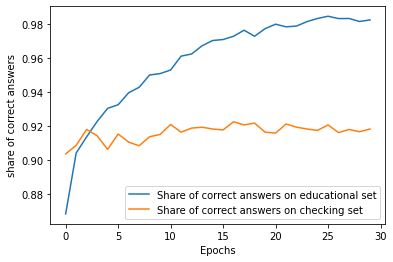

In [32]:
plt.plot(history.history['accuracy'], 
         label='Share of correct answers on educational set')
plt.plot(history.history['val_accuracy'], 
         label='Share of correct answers on checking set')
plt.xlabel('Epochs')
plt.ylabel('share of correct answers')
plt.legend()
plt.show()

In [33]:
scores = model.evaluate(features_test, labels_test, verbose=1)
print("Аккуратность на тестовых данных: %.2f%%" % (scores[1]*100))

118/118 [==============================] - 0s 3ms/step - loss: 0.3556 - accuracy: 0.9125
Аккуратность на тестовых данных: 91.25%
